In [1]:
%load_ext autoreload
%autoreload 2

# Analyse result of simulating mutational robustness of sRNA-mRNA 

## Imports

In [33]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.srv.sequence_exploration.sequence_analysis import b_tabulate_mutation_info
from synbio_morpher.utils.common.setup import prepare_config, expand_config
from synbio_morpher.utils.data.data_format_tools.common import load_multiple_as_list
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols


# Combine data from multi-thread

## Simulation settings

In [3]:
config = {
    "experiment": {
        "purpose": "tests",
    },
    "system_type": "RNA",
    "include_prod_deg": False,
    "interaction_simulator": {
        "name": "IntaRNA",
        "postprocess": True,
        "multithread": 0,
        "simulator_kwargs": {
            "outcsvcols": "id1,id2,E,E_norm,subseqDB,Pu1,Pu2"
        }
    },
    "mutations_args": {
        "algorithm": "all",
        "mutation_counts": 0,
        "mutation_nums_within_sequence": [1],
        "mutation_nums_per_position": 1,
        "concurrent_species_to_mutate": "single_species_at_a_time",
        "seed": 0
    },
    "simulation": {
        "dt0": 0.1,
        "t0": 0,
        "t1": 100,
        "tmax": 2000,
        "solver": "diffrax",
        "use_batch_mutations": True,
        "interaction_factor": 1,
        "batch_size": 200,
        "max_circuits": 2000,
        "device": "cpu",
        "threshold_steady_states": 0.05,
        "use_rate_scaling": True
    },
    "molecular_params": {
        "avg_mRNA_per_cell": 100,
        "cell_doubling_time": 1200,
        "creation_rate": 2.35,
        "starting_copynumbers": 200,
        "degradation_rate": 0.01175,
        "association_binding_rate": 1000000
    }
}

data_writer = None
config, data_writer = script_preamble(config, data_writer)
config_file = expand_config(config=config)
config_file = prepare_config(config_file)

## Load data

In [60]:
fn = '../data/sRNA/merged_inter.csv'
data = pd.read_csv(fn)
try:
    data = data.drop(columns=['Unnamed: 0'])
except:
    pass
data = data[data['Sequence 1'].apply(lambda x: type(x) == str)]
data = data[data['Sequence 2'].apply(lambda x: type(x) == str)]
data

,Interactor 1,Interactor 2,ID 1,ID 2,Category 1,Category 2,Regulation,Binding position 1,Binding position 2,Sequence 1,Sequence 2,Source DB,Genome position 1,Genome position 2,Strand 1,Strand 2,Sequence before 1,Sequence before 2,Sequence after 1,Sequence after 2
0,dsrA,dsrB,NCBI:946470,NCBI:946468,sRNA,mRNA,NaN,NaN,NaN,AACACATCAGATTTCCTGGTGTAACGAATTTTTTAAGTGCTTCTTG...,TAAATGNAAACAAGTTTTATTTTTATCATCAGAACATTCTAATAAA...,RNAInter,NaN,NaN,NaN,NaN,ttcatcaccttatccgcaatttttttcgctgacaagaaaatattcg...,atcgttttcctcctgtggctttgtgccagtgtagaacaatttcgtt...,cgtgaggtcagcgtcgatgtcgatgccctgctggcggcgatcaatg...,NaN
1,dsrA,ilvH,NCBI:946470,NCBI:947267,sRNA,mRNA,NaN,NaN,NaN,AACACATCAGATTTCCTGGTGTAACGAATTTTTTAAGTGCTTCTTG...,ATTCGCCACAACAAGGACAGGAAGGTTCGGCGCAAGGAGCCCAAGA...,RNAInter,NaN,NaN,NaN,NaN,ttcatcaccttatccgcaatttttttcgctgacaagaaaatattcg...,ATTCGCCACAACAAGGACAGGAAGGTTCGGCGCAAGGAGCCCAAGA...,cgtgaggtcagcgtcgatgtcgatgccctgctggcggcgatcaatg...,ATTCGCCACAACAAGGACAGGAAGGTTCGGCGCAAGGAGCCCAAGA...
2,oxyS,fhlA,NCBI:2847701,NCBI:947181,sRNA,mRNA,NaN,NaN,NaN,GAAACGGAGCGGCACCTCTTTTAACCCTTGAAGTCACTGCCCGTTT...,CACCAGATTGCCAAGCTGATGGTCGAGCTGTCCAAATCCCAGGATG...,RNAInter,NaN,NaN,NaN,NaN,TTTGCGAACTTATCGGTTTCGTATTGAGGGCAATAAACTCTCGAGG...,CACCAGATTGCCAAGCTGATGGTCGAGCTGTCCAAATCCCAGGATG...,TTTGCGAACTTATCGGTTTCGTATTGAGGGCAATAAACTCTCGAGG...,CACCAGATTGCCAAGCTGATGGTCGAGCTGTCCAAATCCCAGGATG...
3,sgrS,hfq,NCBI:4056038,NCBI:948689,sRNA,mRNA,NaN,NaN,NaN,GATGAAGCAAGGGGGTGCCCCATGCGTCAGTTTTATCAGCACTATT...,ATGGCTAAGGGGCAATCTTTACAAGATCCGTTCCTGAACGCACTGC...,RNAInter,NaN,NaN,NaN,NaN,ttgagcagggtgcgcatatgacgacgcgagcagctcaataacgctg...,cgaagcggcagataacctggctgcgtggttgggaaggggttcactg...,ttattctcgccgcgctaaaaagggaacgtatgatctggataatgac...,aaggtttcgggctgtttttttacacggggagccagcgatcctgcgt...
4,oxyS,nusG,NCBI:2847701,NCBI:948485,sRNA,mRNA,NaN,NaN,NaN,GAAACGGAGCGGCACCTCTTTTAACCCTTGAAGTCACTGCCCGTTT...,ATGTCTGAAGCTCCTAAAAAGCGCTGGTACGTCGTTCAGGCGTTTT...,RNAInter,NaN,NaN,NaN,NaN,TTTGCGAACTTATCGGTTTCGTATTGAGGGCAATAAACTCTCGAGG...,cgacaaaaggtaaagctaccgttgcttttgcccgtgaagcgcgtac...,TTTGCGAACTTATCGGTTTCGTATTGAGGGCAATAAACTCTCGAGG...,aacccagcgatcaaaaaagcggcgatttaatcgttgcacaaggcgt...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,ryhB,msrA,"chromosome:NC_000913.3, Gene ID:2847761","chromosome:NC_000913.3, Gene ID:948734",sRNA,mRNA,No Interaction,['NA'],['NA'],GCGATCAGGAAGACCCTCGCGGAGAACCTGAAAGCACGACATTGCT...,ATGAGTTTATTTGATAAAAAGCATCTGGTTTCCCCCGCCGATGCCC...,sRNATarBase,3580927..3581016,4441538..4442176,reverse,reverse,TTTGAGAGCGTCTCTGTCCCTCGTTTTGCGGTTAAGCCGCATCCAT...,atggtgtcgctctcccgaaaatcggtcattggggttaaggttgtaa...,TTTGAGAGCGTCTCTGTCCCTCGTTTTGCGGTTAAGCCGCATCCAT...,aggtactgtaaagccgccagagggttaaaattcagacagctgaaaa...
374,gcvB,hdeA,"chromosome:NC_000913.3, Gene ID:2847720","chromosome:NC_000913.3, Gene ID:948025",trans-encoded antisense RNA,mRNA,Induction,['NA'],['NA'],ACTTCCTGAGCCGGAACGAAAAGTTTTATCGGAATGCGTGTTCTGG...,ATGAAAAAAGTATTAGGCGTTATTCTTGGTGGTCTGCTTCTTCTGC...,sRNATarBase,2942696..2942901,3656408..3656740,forward,reverse,GGTAGAGCGCCATTGCATTCTTTAGCGCCTCGATCCCTTTATTTTT...,atcgtaatatcctcaactataaagtgaaagagccgtcacgaatcaa...,GGTAGAGCGCCATTGCATTCTTTAGCGCCTCGATCCCTTTATTTTT...,gccaacgcagattgtgcgttcaccagtgacaaagccgctacagcgc...
375,gcvB,hdeB,"chromosome:NC_000913.3, Gene ID:2847720","chromosome:NC_000913.3, Gene ID:948026",trans-encoded antisense RNA,mRNA,Induction,['NA'],['NA'],ACTTCCTGAGCCGGAACGAAAAGTTTTATCGGAATGCGTGTTCTGG...,ATGAATATTTCATCTCTCCGTAAAGCGTTTATTTTTATGGGCGCTG...,sRNATarBase,2942696..2942901,3655966..3656292,forward,reverse,GGTAGAGCGCCATTGCATTCTTTAGCGCCTCGATCCCTTTATTTTT...,attttgtaacccattcaatatagagattatatatgaacaggaggaa...,GGTAGAGCGCCATTGCATTCTTTAGCGCCTCGATCCCTTTATTTTT...,cataaacagggcgcttcccatgccaattaatacatgtgtgcgtaac...
376,Esr41,fliC,"chromosome:NC_002695.1, Gene ID:","chromosome:NC_002695.1, Gene ID:",trans-encoded antisense RNA,mRNA,Induction,['NA'],['NA'],GATGCTCTAGGCATCACATTTTCTCCATGGGGTATTCCCTCCGCCG...,ATGGCACAAGTCATTAATACCAACAGCCTCTCGCTGATCACTCAAA...,sRNATarBa

In [4]:
source_dirs = [
    "data/tests/2024_01_21_201544",
    "data/tests/2024_01_21_201545",
    "data/tests/2024_01_21_201546",
    "data/tests/2024_01_21_201547",
    "data/tests/2024_01_21_201548",
    "data/tests/2024_01_21_201549",
    "data/tests/2024_01_21_201550",
    "data/tests/2024_01_21_201551",
    "data/tests/2024_01_21_201552",
    "data/tests/2024_01_21_201553",
    "data/tests/2024_01_21_201554",
    "data/tests/2024_01_21_201555",
    "data/tests/2024_01_21_201557",
    "data/tests/2024_01_21_201558",
    "data/tests/2024_01_21_201559",
    "data/tests/2024_01_21_201601",
    "data/tests/2024_01_21_201602",
    "data/tests/2024_01_21_201604",
    "data/tests/2024_01_21_201605",
    "data/tests/2024_01_21_201606",
    "data/tests/2024_01_21_201607",
    "data/tests/2024_01_21_201608",
    "data/tests/2024_01_21_201609"
]

### Edit mutation csv's

In [5]:
# Correcting mistakenly overwritten mutation files

too_few = []
too_many = []
for topdir in source_dirs:
    for circuit_dir in sorted(os.listdir(topdir)):
        if os.path.isdir(os.path.join(topdir, circuit_dir, 'mutations')):
            fn_muts = os.path.join(topdir, circuit_dir, 'mutations_og.csv')
            fn_muts_new = os.path.join(topdir, circuit_dir, 'mutations.csv')
            if os.path.isfile(fn_muts):
                mutations = pd.read_csv(fn_muts, index_col='mutation_name')
                mutations_new = pd.read_csv(fn_muts_new, index_col='mutation_name')
                actual_mutations = sorted(os.listdir(os.path.join(topdir, circuit_dir, 'mutations')))
                if len(actual_mutations) > len(mutations):
                    print('less', topdir, circuit_dir)
                    too_many.append(os.path.join(topdir, circuit_dir))
                elif len(actual_mutations) < len(mutations):
                    print('more', topdir, circuit_dir)
                    too_few.append(os.path.join(topdir, circuit_dir))
                if len(actual_mutations) == len(mutations) and (len(actual_mutations) != len(mutations_new)):
                    print('correcting', topdir, circuit_dir)
                    mutations.loc[actual_mutations].to_csv(fn_muts_new)

more data/tests/2024_01_21_201548 yagJ_fecA
more data/tests/2024_01_21_201552 yagJ_fecD
more data/tests/2024_01_21_201553 yagJ_ibsC
more data/tests/2024_01_21_201602 yagJ_ascF
more data/tests/2024_01_21_201602 yagJ_atoD
more data/tests/2024_01_21_201602 yagJ_caiA
more data/tests/2024_01_21_201602 yagJ_cpxR
more data/tests/2024_01_21_201602 yagJ_folE
more data/tests/2024_01_21_201602 yagJ_fucP
more data/tests/2024_01_21_201602 yagJ_gdhA
more data/tests/2024_01_21_201602 yagJ_ibsA
more data/tests/2024_01_21_201602 yagJ_icd
more data/tests/2024_01_21_201602 yagJ_paaK
more data/tests/2024_01_21_201602 yagJ_phoE
more data/tests/2024_01_21_201602 yagJ_puuE
more data/tests/2024_01_21_201602 yagJ_sucC
more data/tests/2024_01_21_201606 yagJ_ldrC


In [6]:
# correct the baddies

correct_dir = 'data/tests/2024_01_21_201551/yagJ_ibsC'

for circuit_dir in too_few:
    fn_muts = os.path.join(circuit_dir, 'mutations_og.csv')
    mutations = pd.read_csv(fn_muts, index_col='mutation_name')
    mutations_correct = pd.read_csv(os.path.join(correct_dir, 'mutations.csv'), index_col='mutation_name')
    actual_mutations = sorted(os.listdir(os.path.join(circuit_dir, 'mutations')))
    if (len(actual_mutations) == len(mutations_correct)) and (len(actual_mutations) > len(mutations)):
        mutations_correct.to_csv(fn_muts)
        mutations_correct.to_csv(fn_muts.replace('_og', ''))
    
    

In [7]:
for topdir in source_dirs:
    for circuit_dir in sorted(os.listdir(topdir)):
        if circuit_dir == 'yagJ_ascF' and (topdir == 'data/tests/2024_01_21_201602'):
            print('hmm')
        if os.path.isdir(os.path.join(topdir, circuit_dir, 'mutations')):
            fn_muts = os.path.join(topdir, circuit_dir, 'mutations_og.csv')
            fn_muts_new = os.path.join(topdir, circuit_dir, 'mutations.csv')
            if not os.path.isfile(fn_muts):
                mutations = pd.read_csv(fn_muts_new, index_col='mutation_name')
                mutations.to_csv(fn_muts)
            else:
                mutations = pd.read_csv(fn_muts, index_col='mutation_name')
            actual_mutations = sorted(os.listdir(os.path.join(topdir, circuit_dir, 'mutations')))
            if len(actual_mutations) != len(mutations):
                mutations.loc[actual_mutations].drop_duplicates().to_csv(fn_muts_new)

hmm


In [8]:
# len(pd.read_csv('data/tests/2024_01_21_201602/yagJ_ascF/mutations.csv'))
# len(os.listdir('data/tests/2024_01_21_201602/yagJ_ascF/mutations'))

## Load up tabulated data

In [13]:
fn = 'data/04_distribution_mutational_robustness/2024_01_25_140808/tabulated_mutation_info.csv'
if os.path.isfile(fn):
    saves = pd.read_csv(fn)
else:
    tables = load_multiple_as_list(inputs_list=source_dirs, load_func=b_tabulate_mutation_info, 
                data_writer=data_writer)
    saves = pd.concat(tables, axis=0)
    # data_writer.output(data=saves, out_name='saves', out_type='csv')
    print(data_writer.write_dir)

In [14]:
saves = saves.drop_duplicates().reset_index()
saves = saves.drop(columns='level_0')


## Process columns

In [42]:
e_cols = get_true_interaction_cols(saves, 'energies', num_species=2, remove_symmetrical=True)
for c in e_cols:
    saves[f'{c}_diffs'] = saves.groupby(by='circuit_name').apply(lambda x: x[x['mutation_name'] == 'ref_circuit'][c].iloc[0] - x[c]).reset_index()[c]
e_cols

['energies_0-0', 'energies_0-1', 'energies_1-1']

In [50]:
saves['mutation_positions'] = saves['mutation_positions'].apply(lambda x: int(x.strip('[]')) if x.strip('[]') else None)
saves['mutation_type'] = saves['mutation_type'].apply(lambda x: int(x.strip('[]')) if x.strip('[]') else None)

In [65]:
data['Category 1'].unique()
srnas = {k: seq for k, seq in zip(data[data['Category 1'].isin(['sRNA', 'pseudo', 'trans-encoded antisense RNA'])]
                                  ['Interactor 1'].to_list() + data[data['Category 2'].isin(['sRNA'])]['Interactor 2'].to_list(),
                                  data[data['Category 1'].isin(['sRNA', 'pseudo', 'trans-encoded antisense RNA'])]
                                  ['Sequence 1'].to_list() + data[data['Category 2'].isin(['sRNA'])]['Sequence 2'].to_list())}

### Get the mutation position relative within the sRNA binding region

In [105]:
saves['mutation_positions_relative'] = saves.groupby(by='circuit_name').apply(lambda x: (
    x['mutation_positions'] - x['mutation_positions'].min()) / (x['mutation_positions'].max() - x['mutation_positions'].min())).reset_index()['mutation_positions']
# - x['name'].str.split(
#     '_').apply(lambda xx: srnas['_'.join(xx[:-1])]).apply(len)
# saves['mutation_positions_relative'] = saves.groupby(by='circuit_name').apply(lambda x: x['mutation_positions'] / (
#     x['mutation_positions'].max() - x['mutation_positions'].min())).reset_index()['mutation_positions']

# Visualise

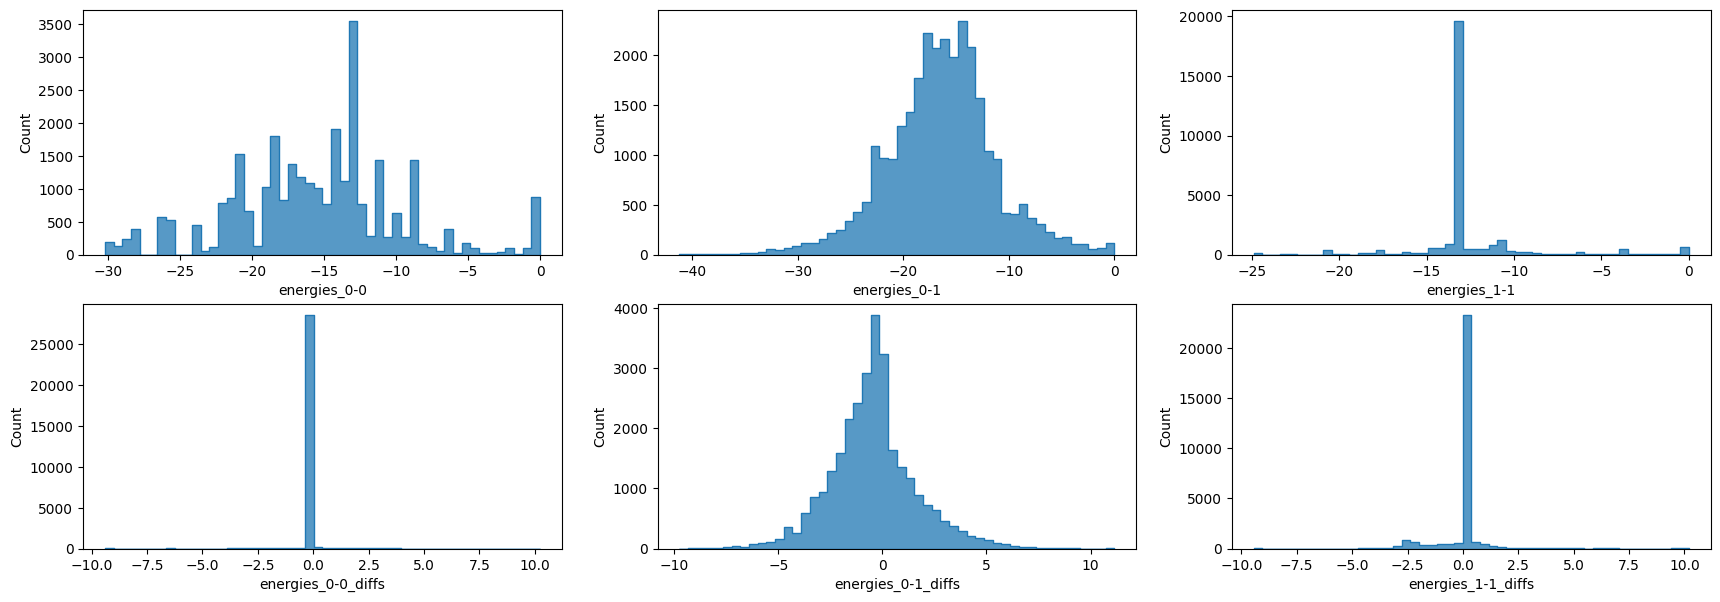

In [43]:
fig = plt.figure(figsize=(7*len(e_cols), 7))
i = 0
for a in ['', '_diffs']:
    for e in e_cols:
        ax = plt.subplot(2, len(e_cols), i+1)
        sns.histplot(saves, x=e + a, bins=50, element='step')
        i = i+1
    

## By binding site

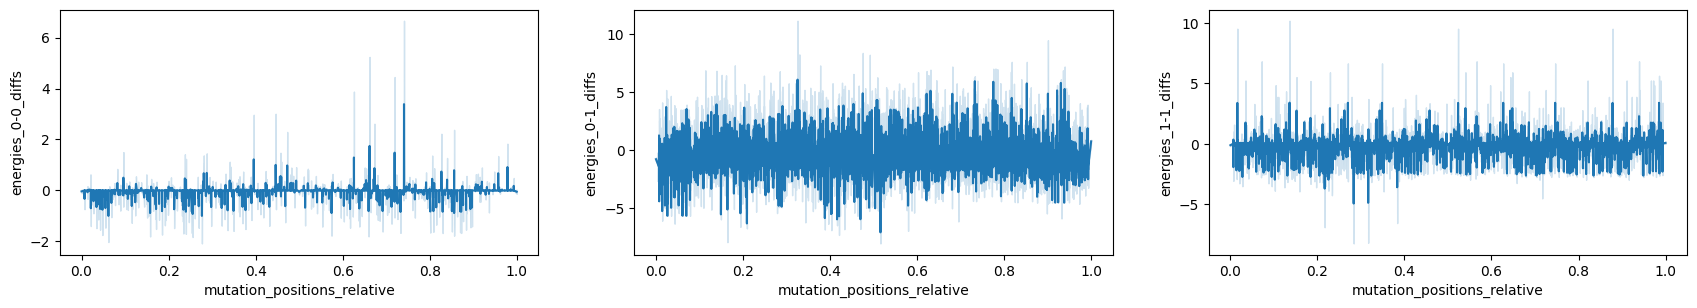

In [108]:

fig = plt.figure(figsize=(7*len(e_cols), 7))
i = 0
for a in ['_diffs']:
    for e in e_cols:
        ax = plt.subplot(2, len(e_cols), i+1)
        sns.lineplot(saves, x='mutation_positions_relative', y=e+a)
        i = i+1
    

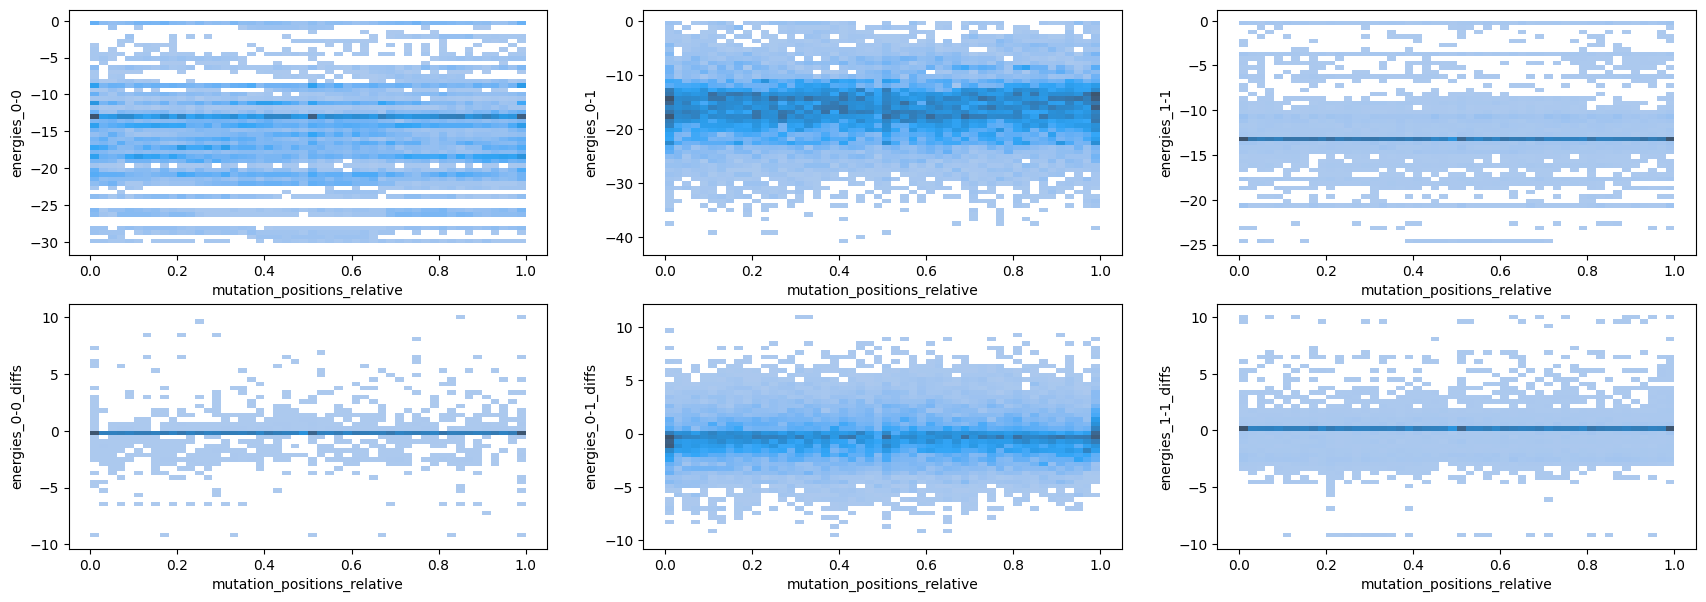

In [107]:

fig = plt.figure(figsize=(7*len(e_cols), 7))
i = 0
for a in ['', '_diffs']:
    for e in e_cols:
        ax = plt.subplot(2, len(e_cols), i+1)
        sns.histplot(saves, x='mutation_positions_relative', y=e+a, bins=50)
        i = i+1
    

Text(0.5, 1.0, 'Change in sRNA-mRNA interaction after 1 mutation')

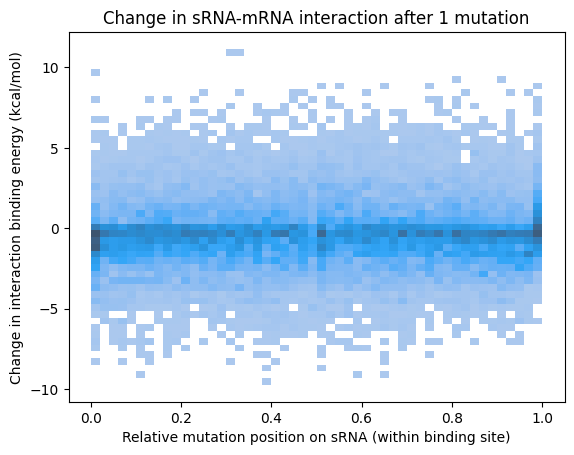

In [112]:

sns.histplot(saves, x='mutation_positions_relative', y='energies_0-1_diffs', bins=50)
plt.xlabel('Relative mutation position on sRNA (within binding site)')
plt.ylabel('Change in interaction binding energy (kcal/mol)')
plt.title('Change in sRNA-mRNA interaction after 1 mutation')
plt.savefig('data/figs/mutations_energy_diff_binding_site.ipynb')

Text(0.5, 1.0, 'Change in sRNA-mRNA interaction after 1 mutation')

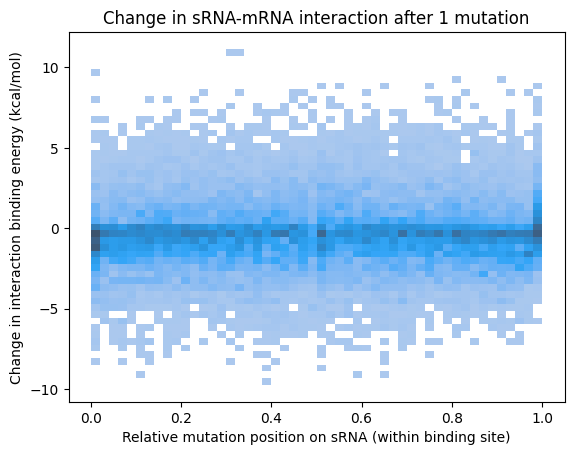

In [113]:

sns.histplot(saves[saves['energies_0-1'] < 0], x='mutation_positions_relative', y='energies_0-1_diffs', bins=50)
plt.xlabel('Relative mutation position on sRNA (within binding site)')
plt.ylabel('Change in interaction binding energy (kcal/mol)')
plt.title('Change in sRNA-mRNA interaction after 1 mutation')
plt.savefig('data/figs/mutations_energy_diff_binding_site_without_noninteractors.ipynb')

## By type

Text(0.5, 1.0, 'Change in sRNA-mRNA interaction after 1 mutation')

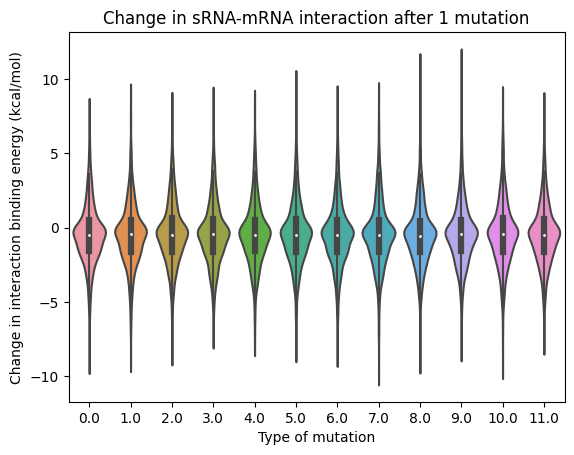

In [130]:
# sns.lineplot(saves, x='mutation_type', y='energies_0-1_diffs')
sns.violinplot(saves, x='mutation_type', y='energies_0-1_diffs')
# sns.histplot(saves, x='mutation_type', y='energies_0-1_diffs', bins=50)
plt.xlabel('Type of mutation')
plt.ylabel('Change in interaction binding energy (kcal/mol)')
plt.title('Change in sRNA-mRNA interaction after 1 mutation')
plt.savefig('data/figs/mutations_energy_diff_mut_type.ipynb')

## Robustness

<Axes: xlabel='energies_0-1', ylabel='Count'>

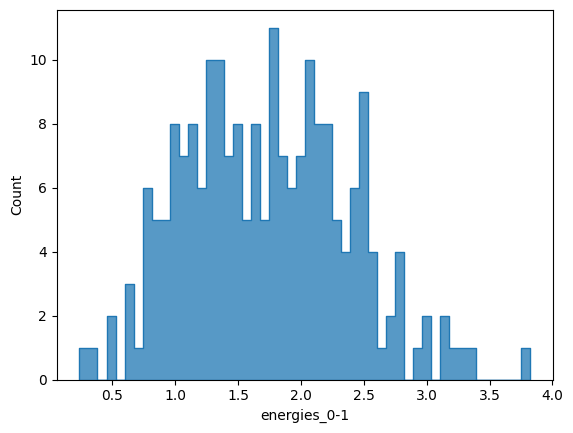

In [138]:
sns.histplot(saves.groupby(by='circuit_name')['energies_0-1'].std(), bins=50, element='step')
plt.title('Robustness of sRNA-mRNA interactions to mutations')